# Results

In [1]:
%reset -f

import ROOT, json
ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.ROOT.EnableImplicitMT(6)

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(3)
ROOT.TH1.AddDirectory(0)


%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i eppi0_bsa.py


rdfs = []
for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)

    cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc,gloosest])
    cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
    cut += "&& abs(dpt)<0.3"
    cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

    df = df.Filter(cut)
    
    rdf = define_eppi0_bins(df, fname)
    rdf = process_eppi0_bins(rdf, fname)
    
    make_allbsas(rdf)
    
    rdfs.append(rdf)

Welcome to JupyROOT 6.26/00


In [2]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0

____________________________

### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

alu = 0.0454*sqrt(x+0.1035);
alu = 0.0433*sqrt(x+0.1038);
alu = 0.0641*sqrt(x+0.1909);
alu = 0.0352*sqrt(x+0.33);
alu = 0.0487*sqrt(x+0.6593);


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


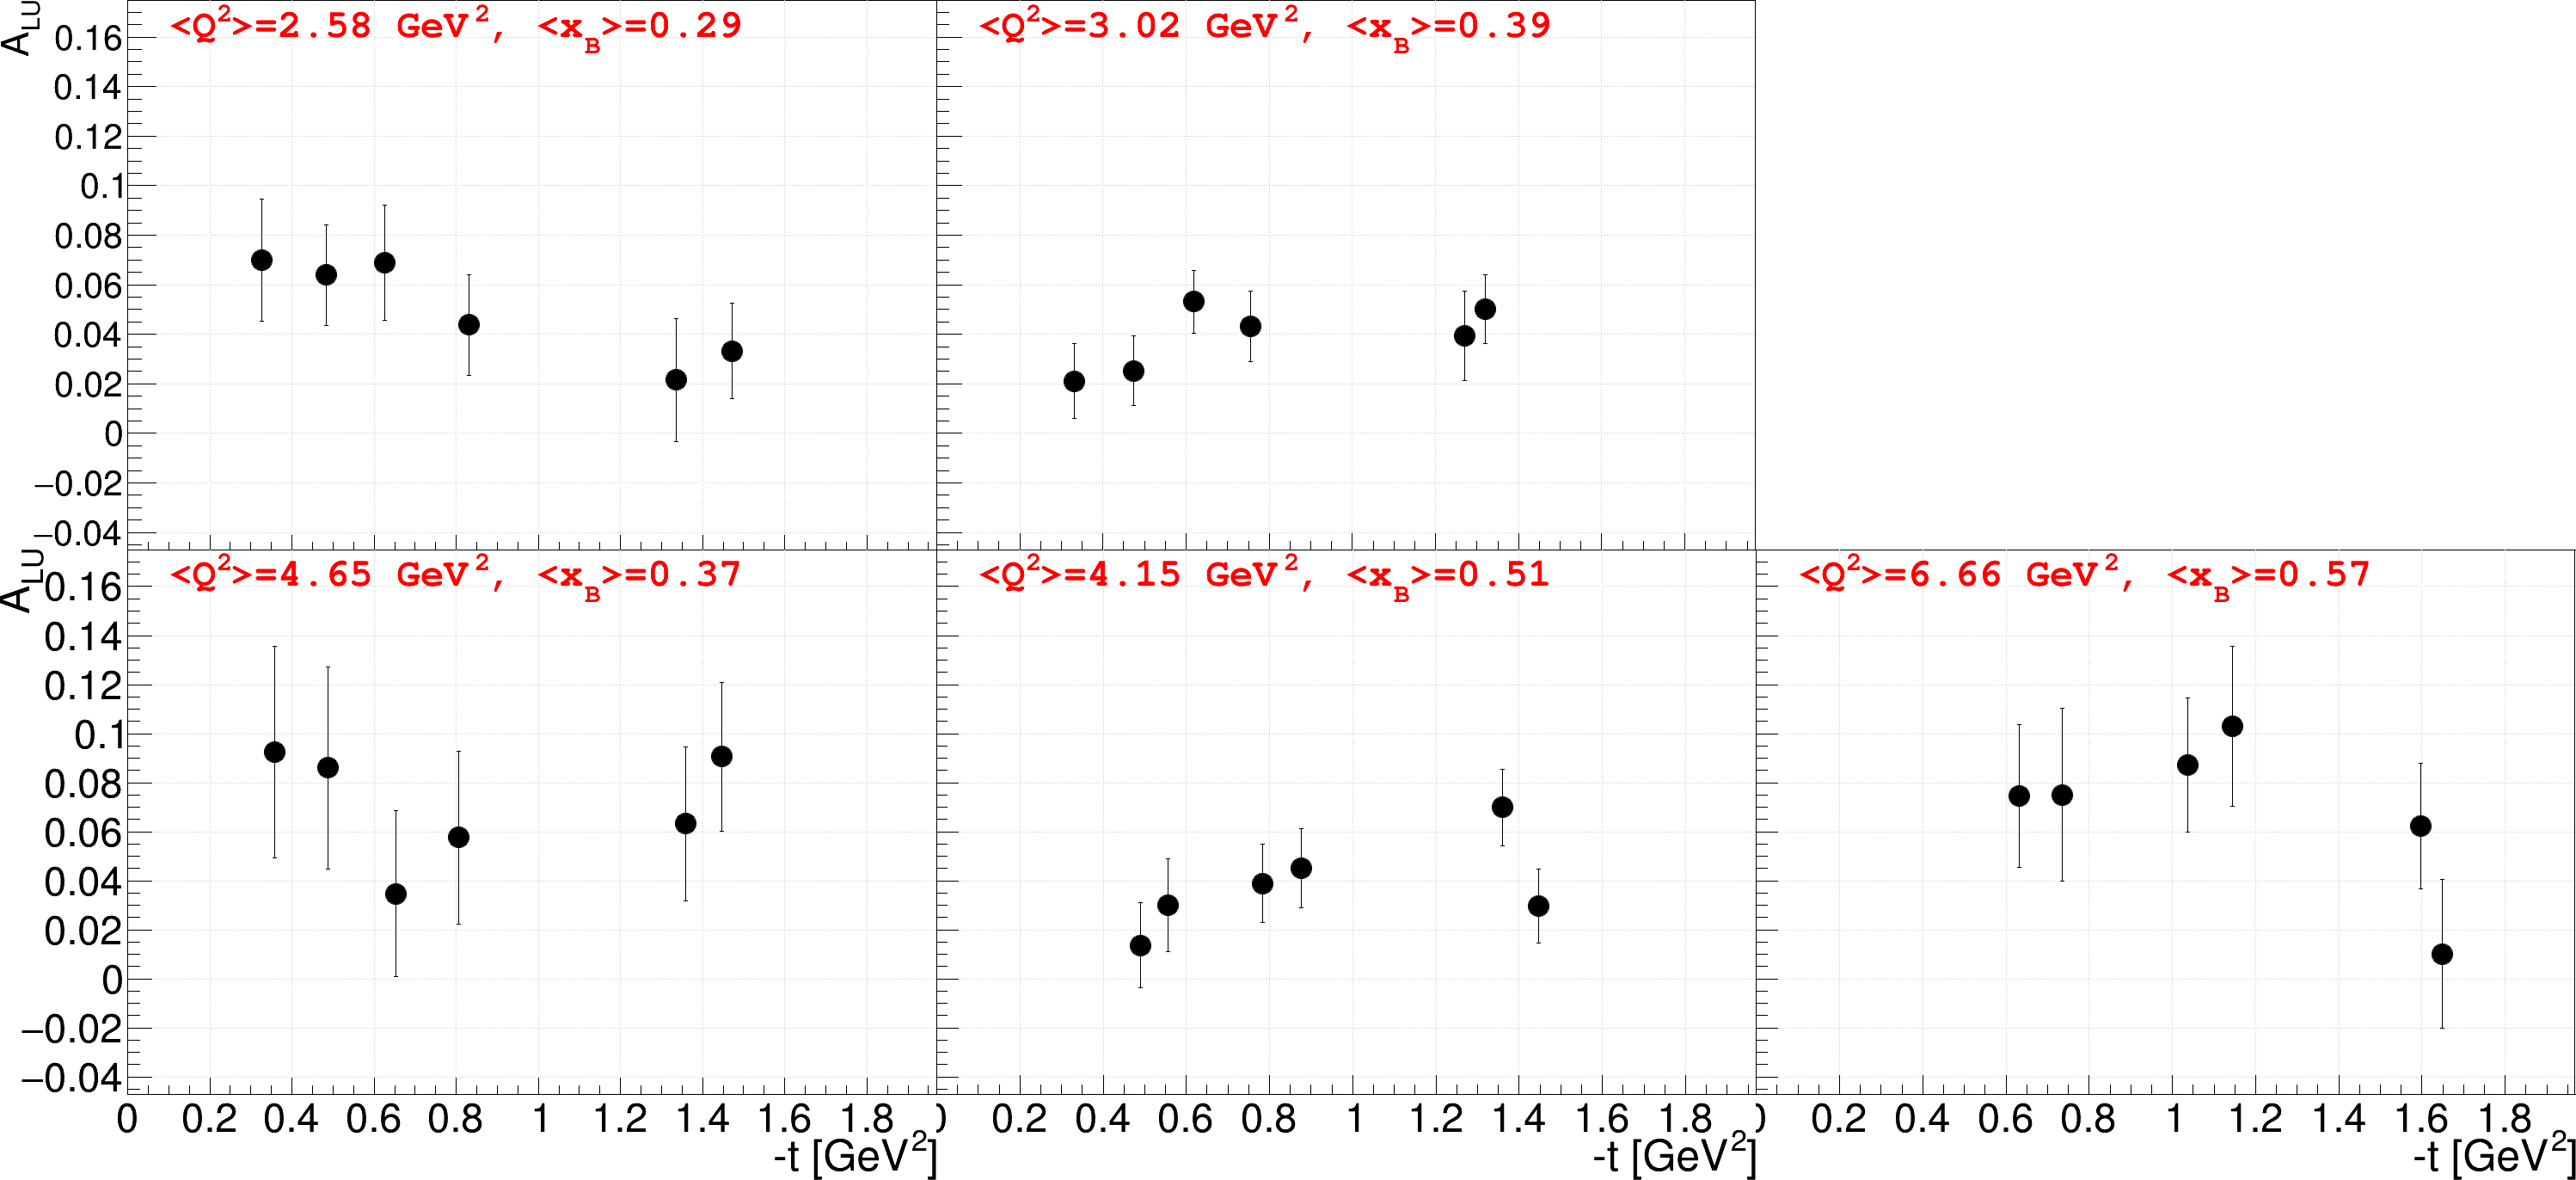

In [3]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

lat = ROOT.TLatex()
lat.SetTextFont(103)
lat.SetTextSize(50)
lat.SetTextColor(2)


data,xydys = [],[]

ipad=0
idf,odf = rdfs[:2]
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[iqdf.binid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    grsys = ROOT.TGraphErrors()
    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.175)
    h1.SetTitle(f";-t [GeV^{{2}}];A_{{LU}}");
    lat.DrawLatex(0.1,0.16,f"<Q^{{2}}>={round(iqdf.q2,2)} GeV^{{2}}, <x_{{B}}>={round(iqdf.xb,2)}")
    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    #for i in range(3):
    #    print(" & ".join(str(round(vv,3)) for vv in [iqdf.tdfs[i].q2, iqdf.tdfs[i].xb, iqdf.tdfs[i].tt, iqdf.grp1.GetPointY(i), iqdf.grp1.GetErrorY(i)]) + " \\\\")
    #    print(" & ".join(str(round(vv,3)) for vv in [oqdf.tdfs[i].q2, oqdf.tdfs[i].xb, oqdf.tdfs[i].tt, oqdf.grp1.GetPointY(i), oqdf.grp1.GetErrorY(i)]) + " \\\\")
    
    gr0.Draw("P")
    for itt in range(3):
        tdf = iqdf.tdfs[itt]
        data.append((tdf.q2, tdf.xb, gr0.GetPointX(itt),gr0.GetPointY(itt),gr0.GetErrorY(itt)))
        tdf = oqdf.tdfs[itt]
        data.append((tdf.q2, tdf.xb, gr1.GetPointX(itt),gr1.GetPointY(itt),gr1.GetErrorY(itt)))

    for itt in range(3):
        gr0.SetPoint(gr0.GetN(), gr1.GetPointX(itt), gr1.GetPointY(itt))
        gr0.SetPointError(gr0.GetN()-1, gr1.GetErrorX(itt), gr1.GetErrorY(itt))
    
    #ft = ROOT.TF1(f"ft.{id(gr0)}","[0]*sqrt(x-[1])*exp([2]+[3]*x)",0,1)
    ft = ROOT.TF1(f"ft.{id(gr0)}","[0]*sqrt(x+[1])",0,1)
    ft.SetParameters(0.3,0.1,-0.5,-0.31)
    tmin = iqdf.xb*iqdf.xb*0.938*0.938/(1-iqdf.xb)
    ft.SetParLimits(1,tmin-0.15,tmin)
    gr0.Fit(ft,"QN")
    
    print(f"alu = {round(ft.GetParameter(0),4)}*sqrt(x+{round(ft.GetParameter(1),4)});")
    xydys.append([(gr0.GetPointX(i),gr0.GetPointY(i),gr0.GetErrorY(i)) for i in range(gr0.GetN())])
    
    gr0.SetMarkerStyle(20)

c1.Print("pdf/results.ALU.pdf")

with open("main.output.data",'w') as ff:
    ff.write(str(xydys))

#with open("main.output.list",'w') as ff:
#    for lls in xydys:
#        for ll in lls:
#            ff.write(str(ll)+"\n")

#for qq,xx,mt,alu,dalu in data:
#    print(" & ".join(str(round(vv,3)) for vv in [qq,xx,mt,alu,dalu]) + " \\\\")


____________________________

### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


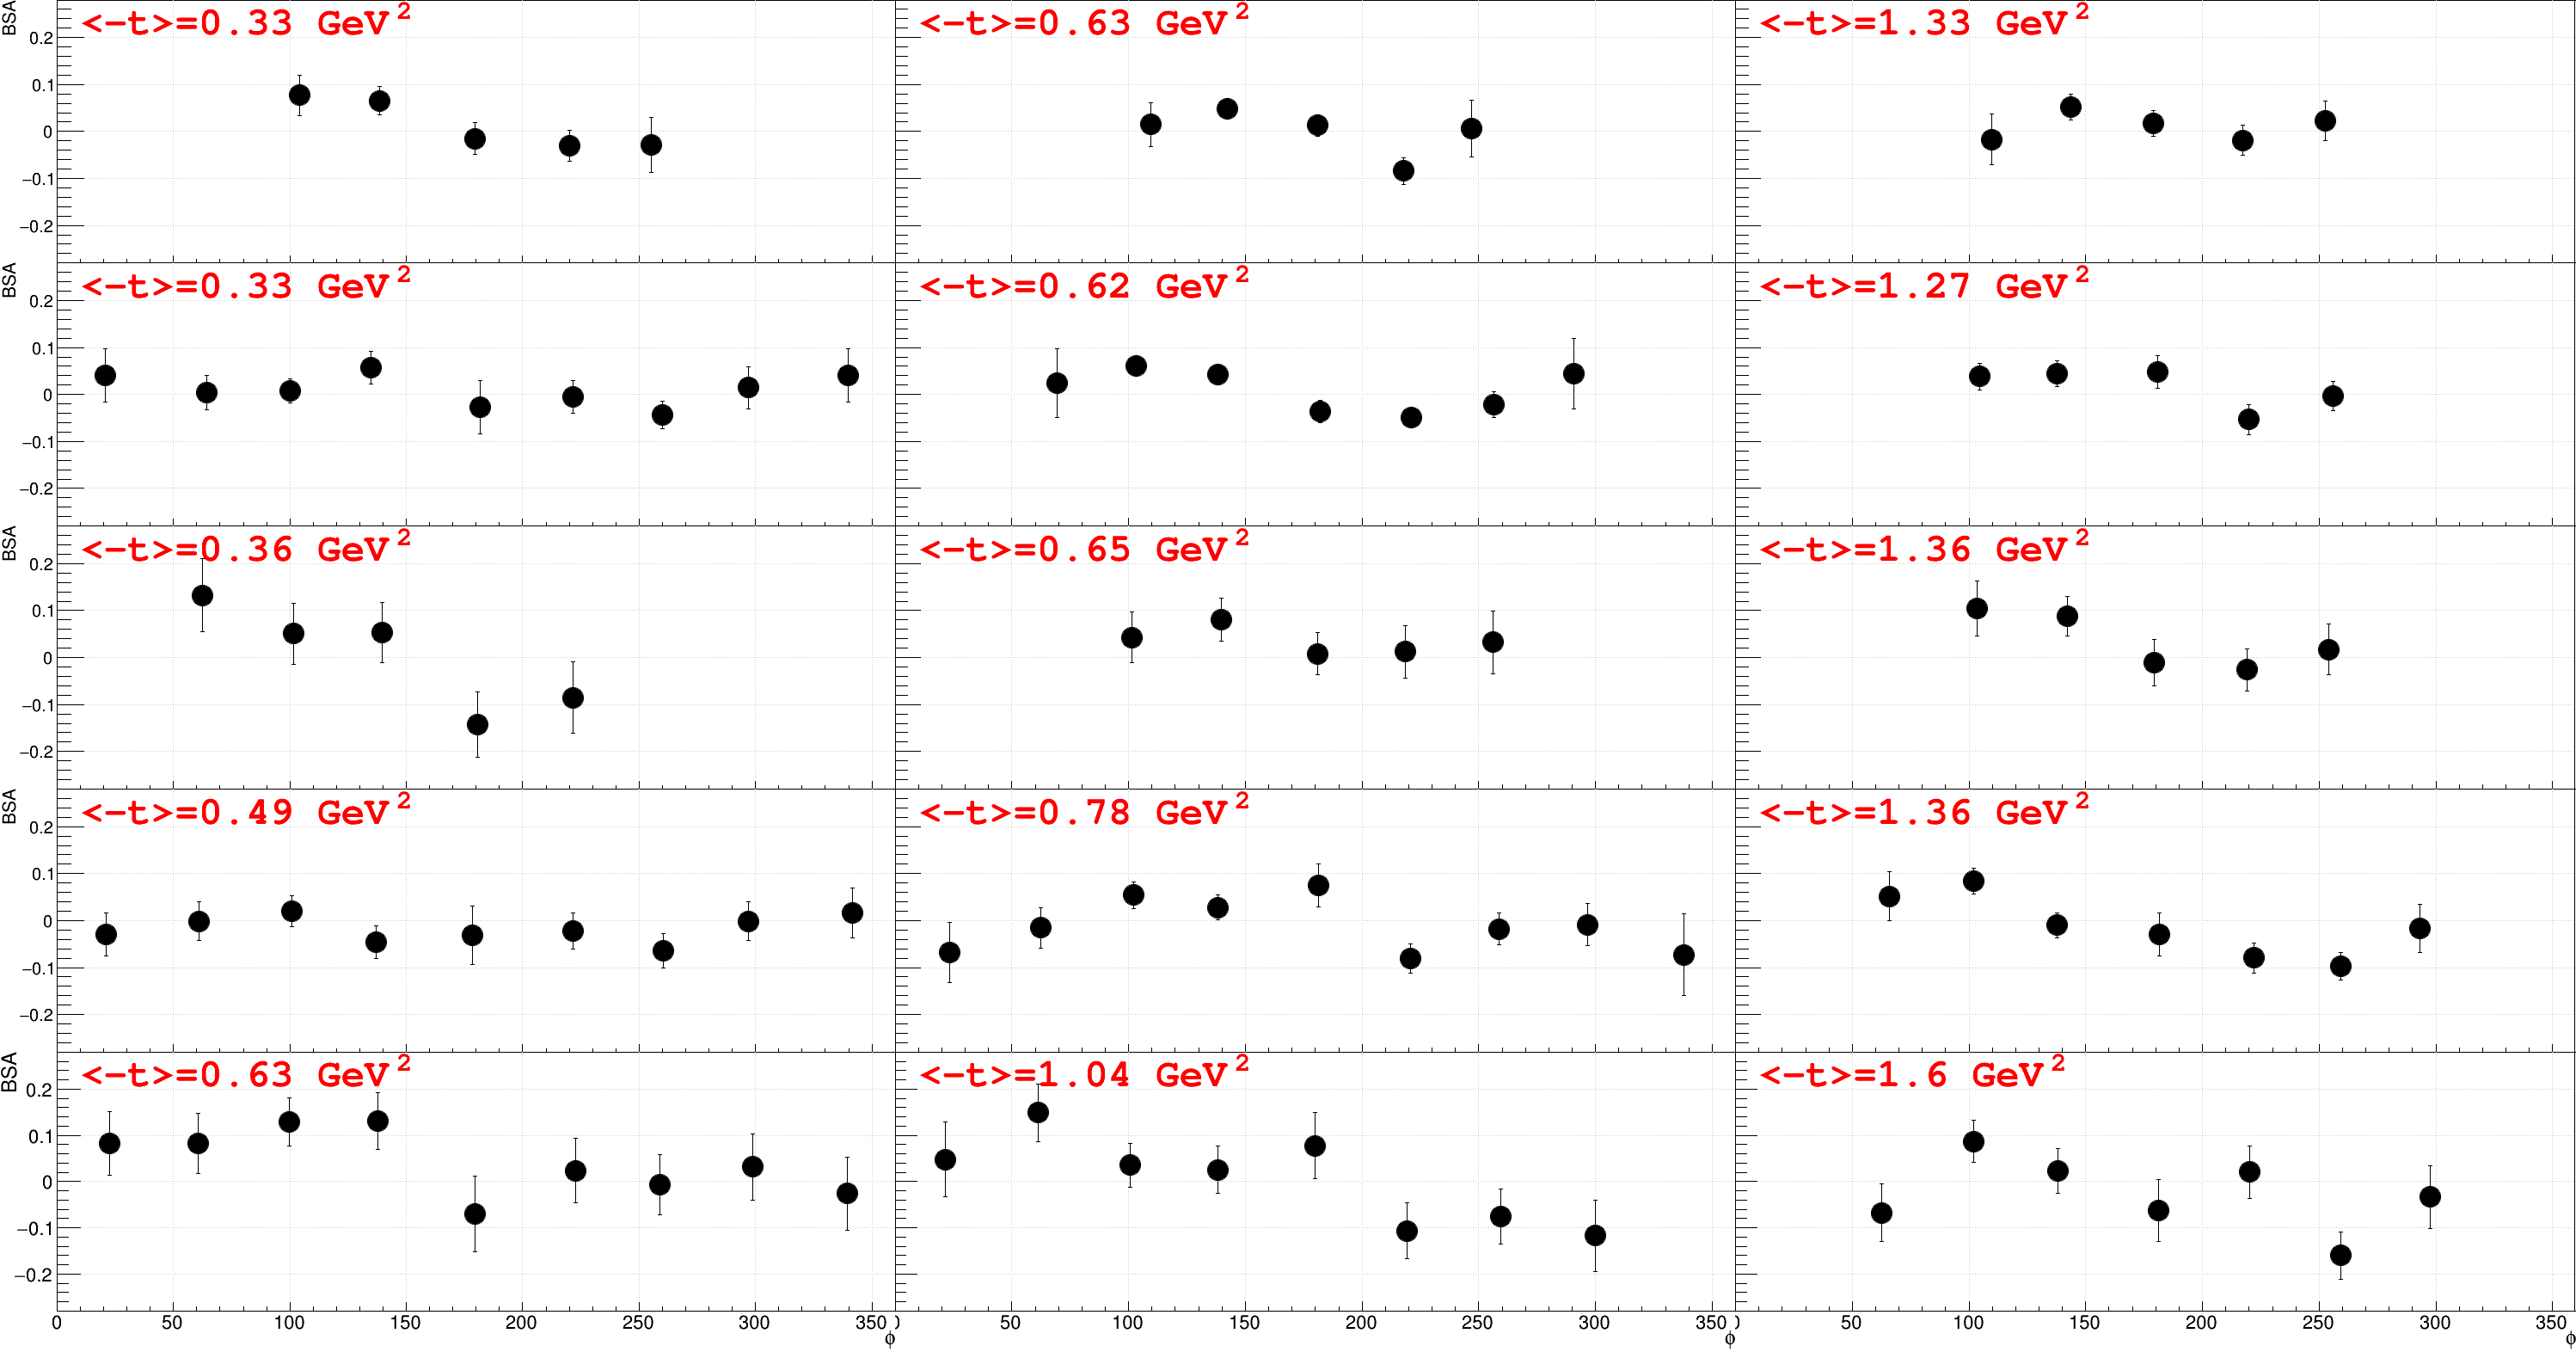

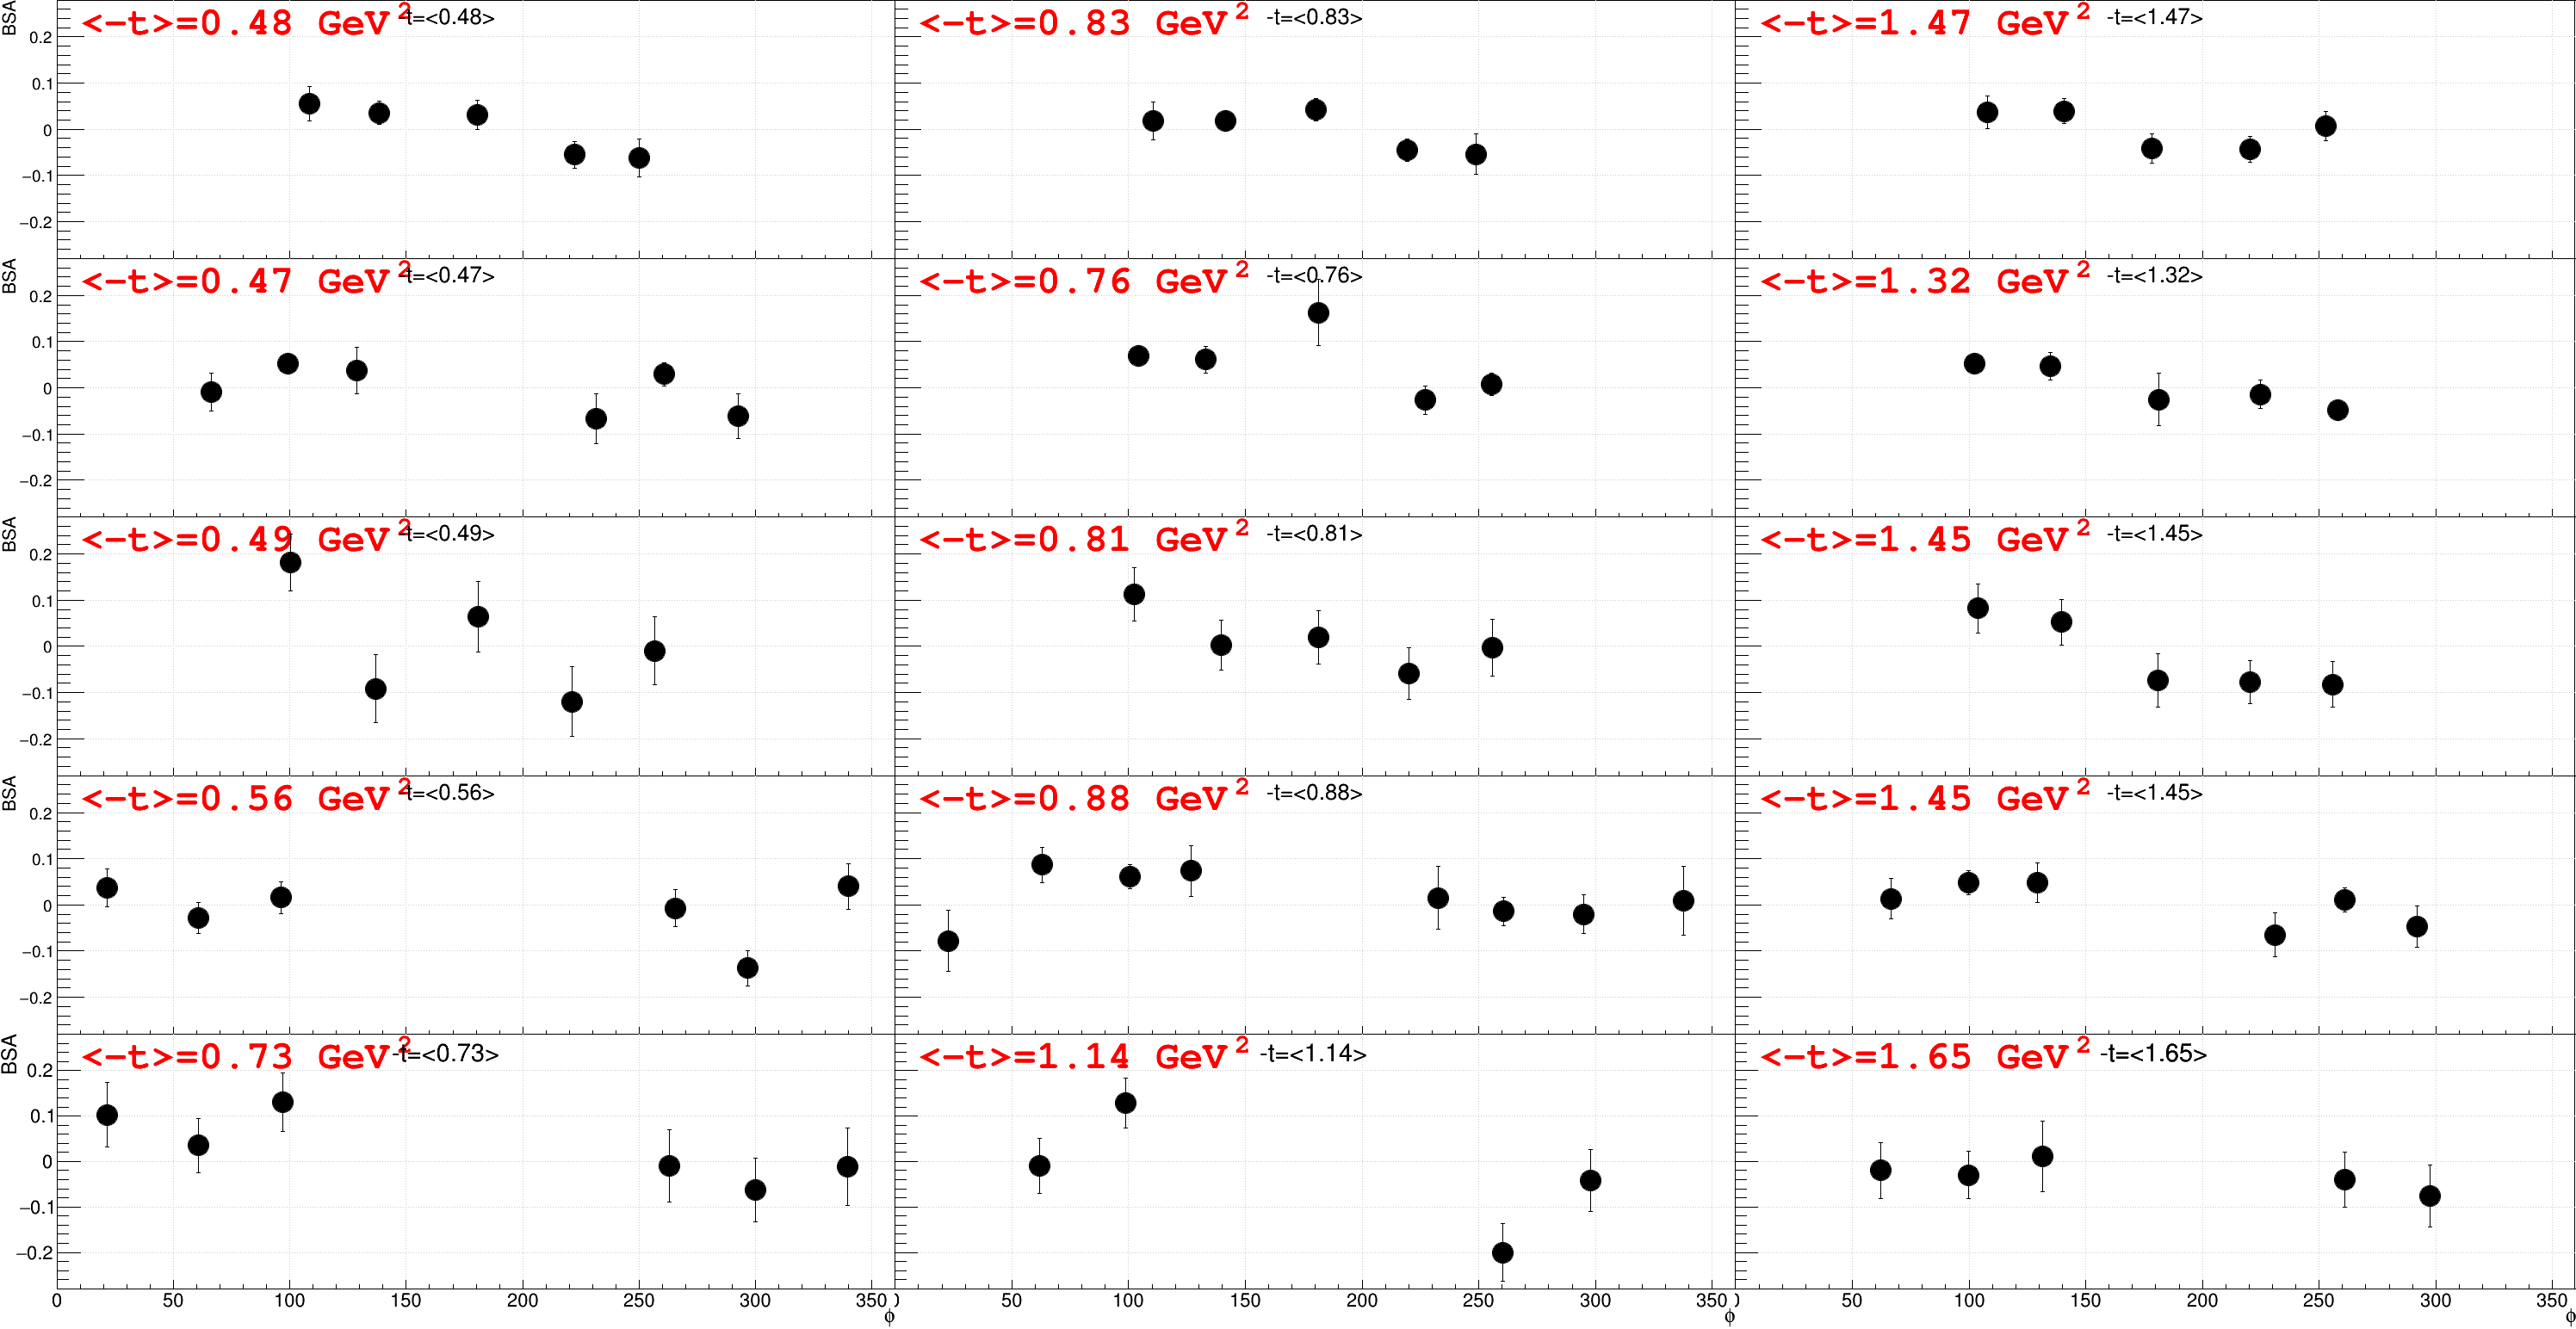

In [4]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

idf,odb = rdfs[:2]

lat = ROOT.TLatex()
lat.SetTextFont(103)
lat.SetTextSize(50)
lat.SetTextColor(2)

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

c1.Draw()
c2 = c1.DrawClone()

ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(";#phi;BSA")
        lat.DrawLatex(10, 0.205, f"<-t>={round(tdf.tt,2)} GeV^{{2}}")
        
        gr0 = tdf.grbsa.Clone()
        gr0.Draw("P")
        gr0.SetMarkerStyle(20)

c1.Print("pdf/results.BSA.inb.pdf")



ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        lat.DrawLatex(10, 0.205, f"<-t>={round(tdf.tt,2)} GeV^{{2}}")

        gr0 = tdf.grbsa.Clone()
        gr0.Draw("P")
        gr0.SetMarkerStyle(20)

c1.Print("pdf/results.BSA.outb.pdf")

____________________________

____________________________

____________________________

# $M_{\gamma\gamma}$ for each $\{Q^2,x_B,-t,\phi\}$ bin

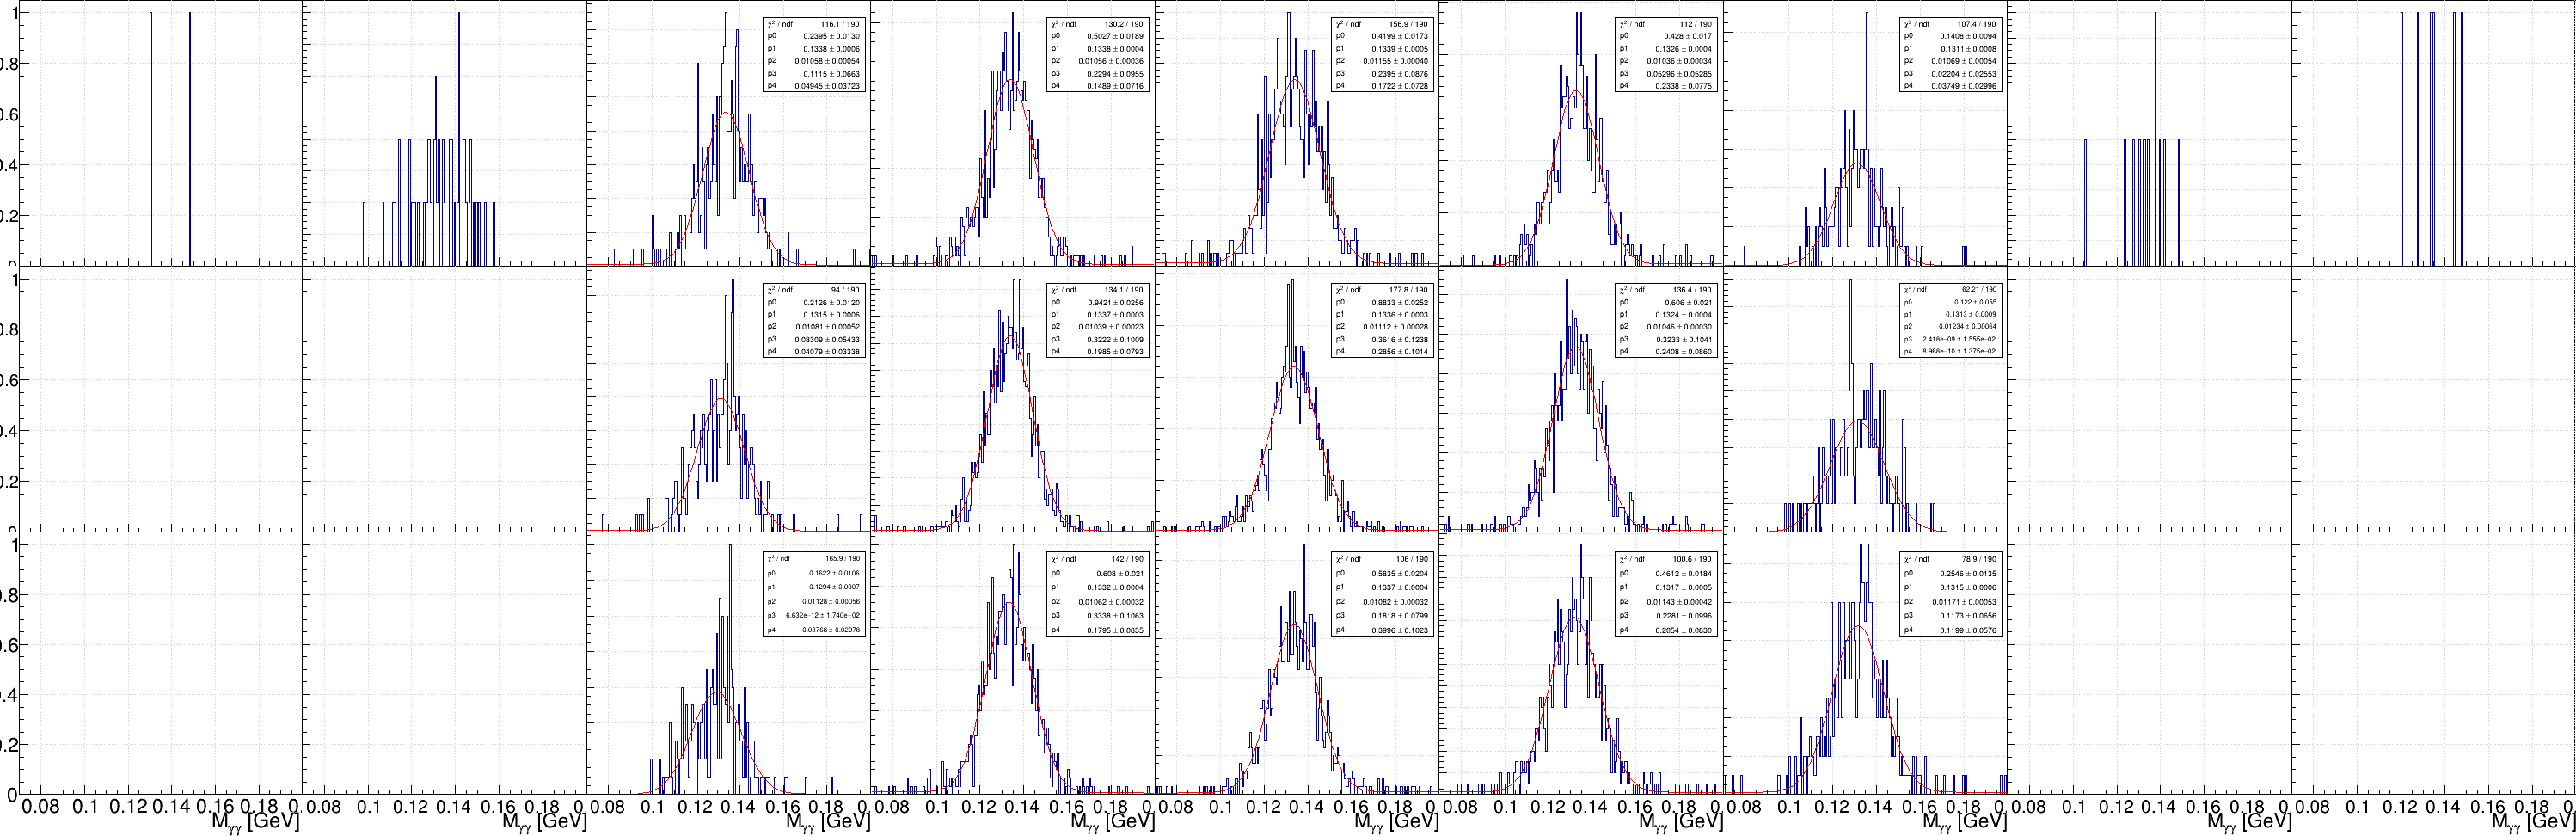

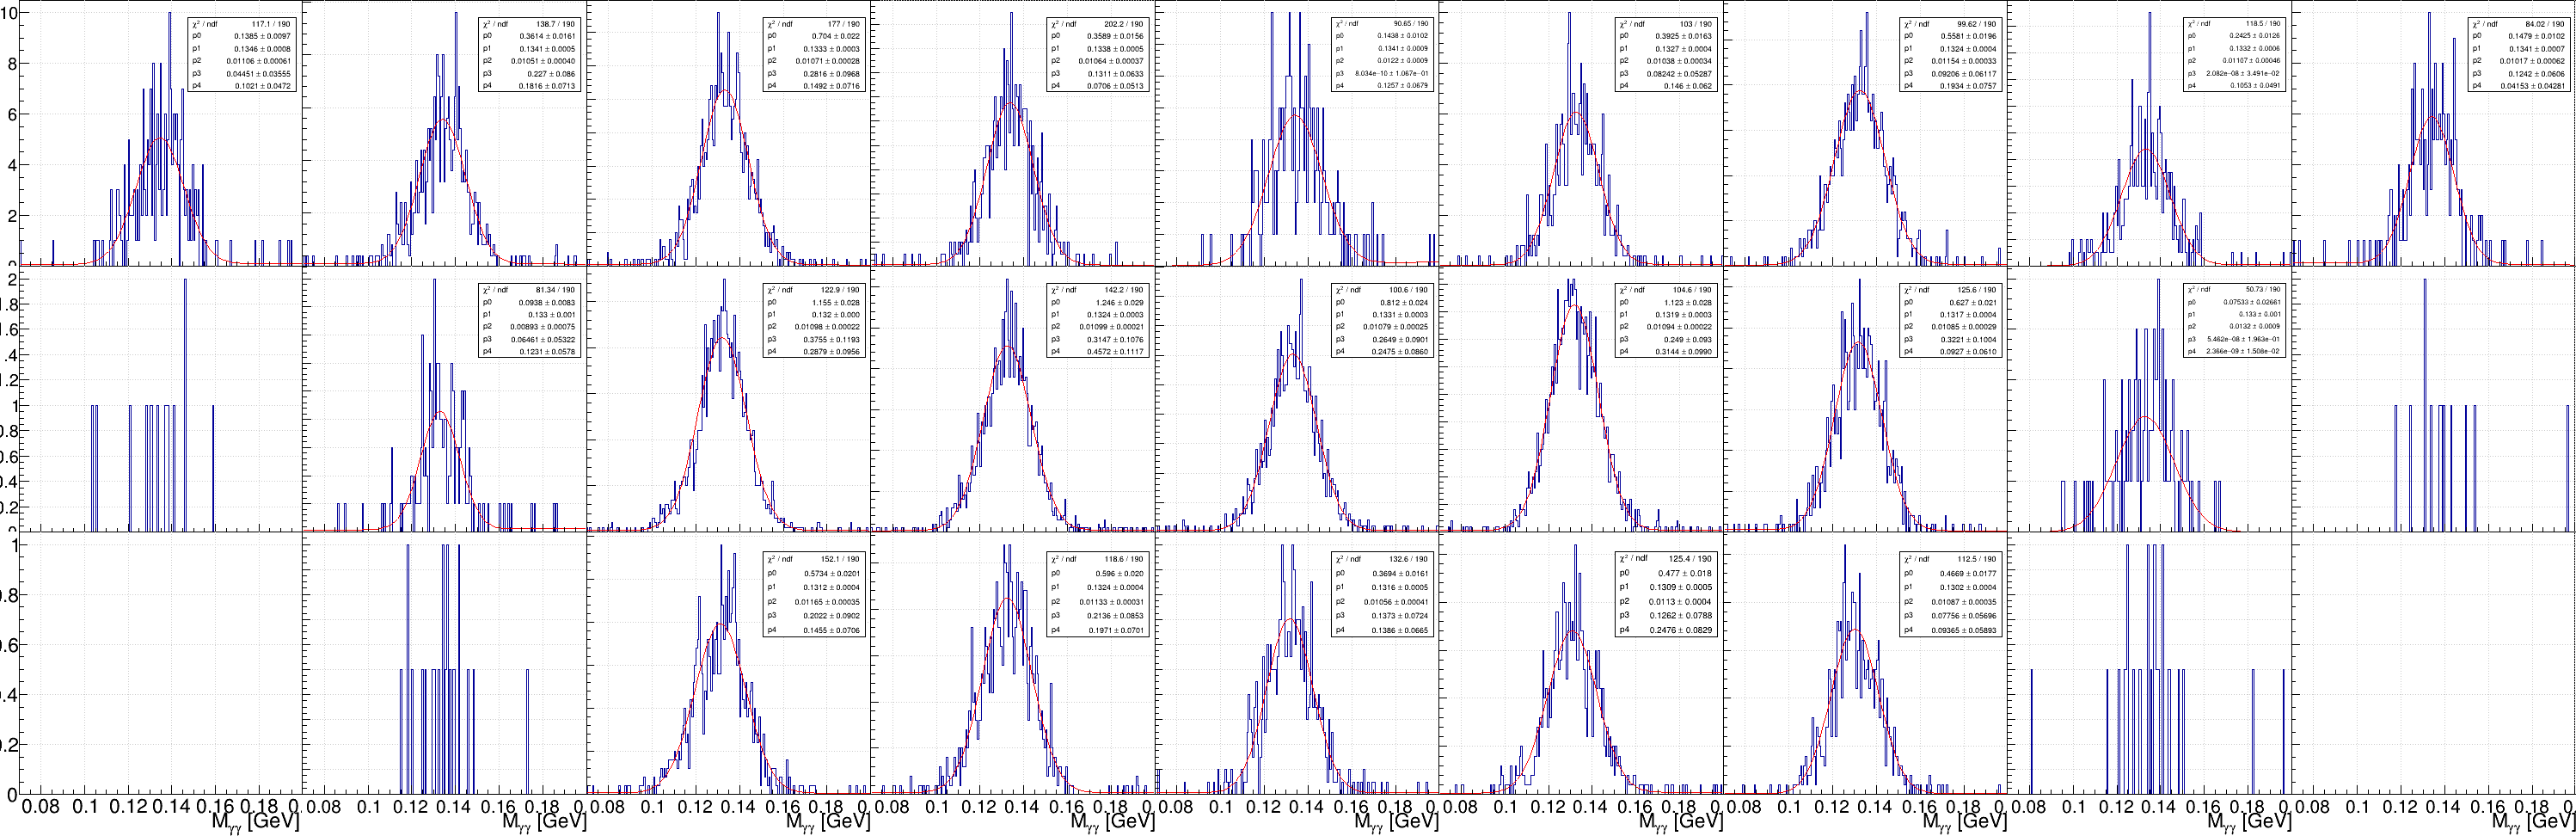

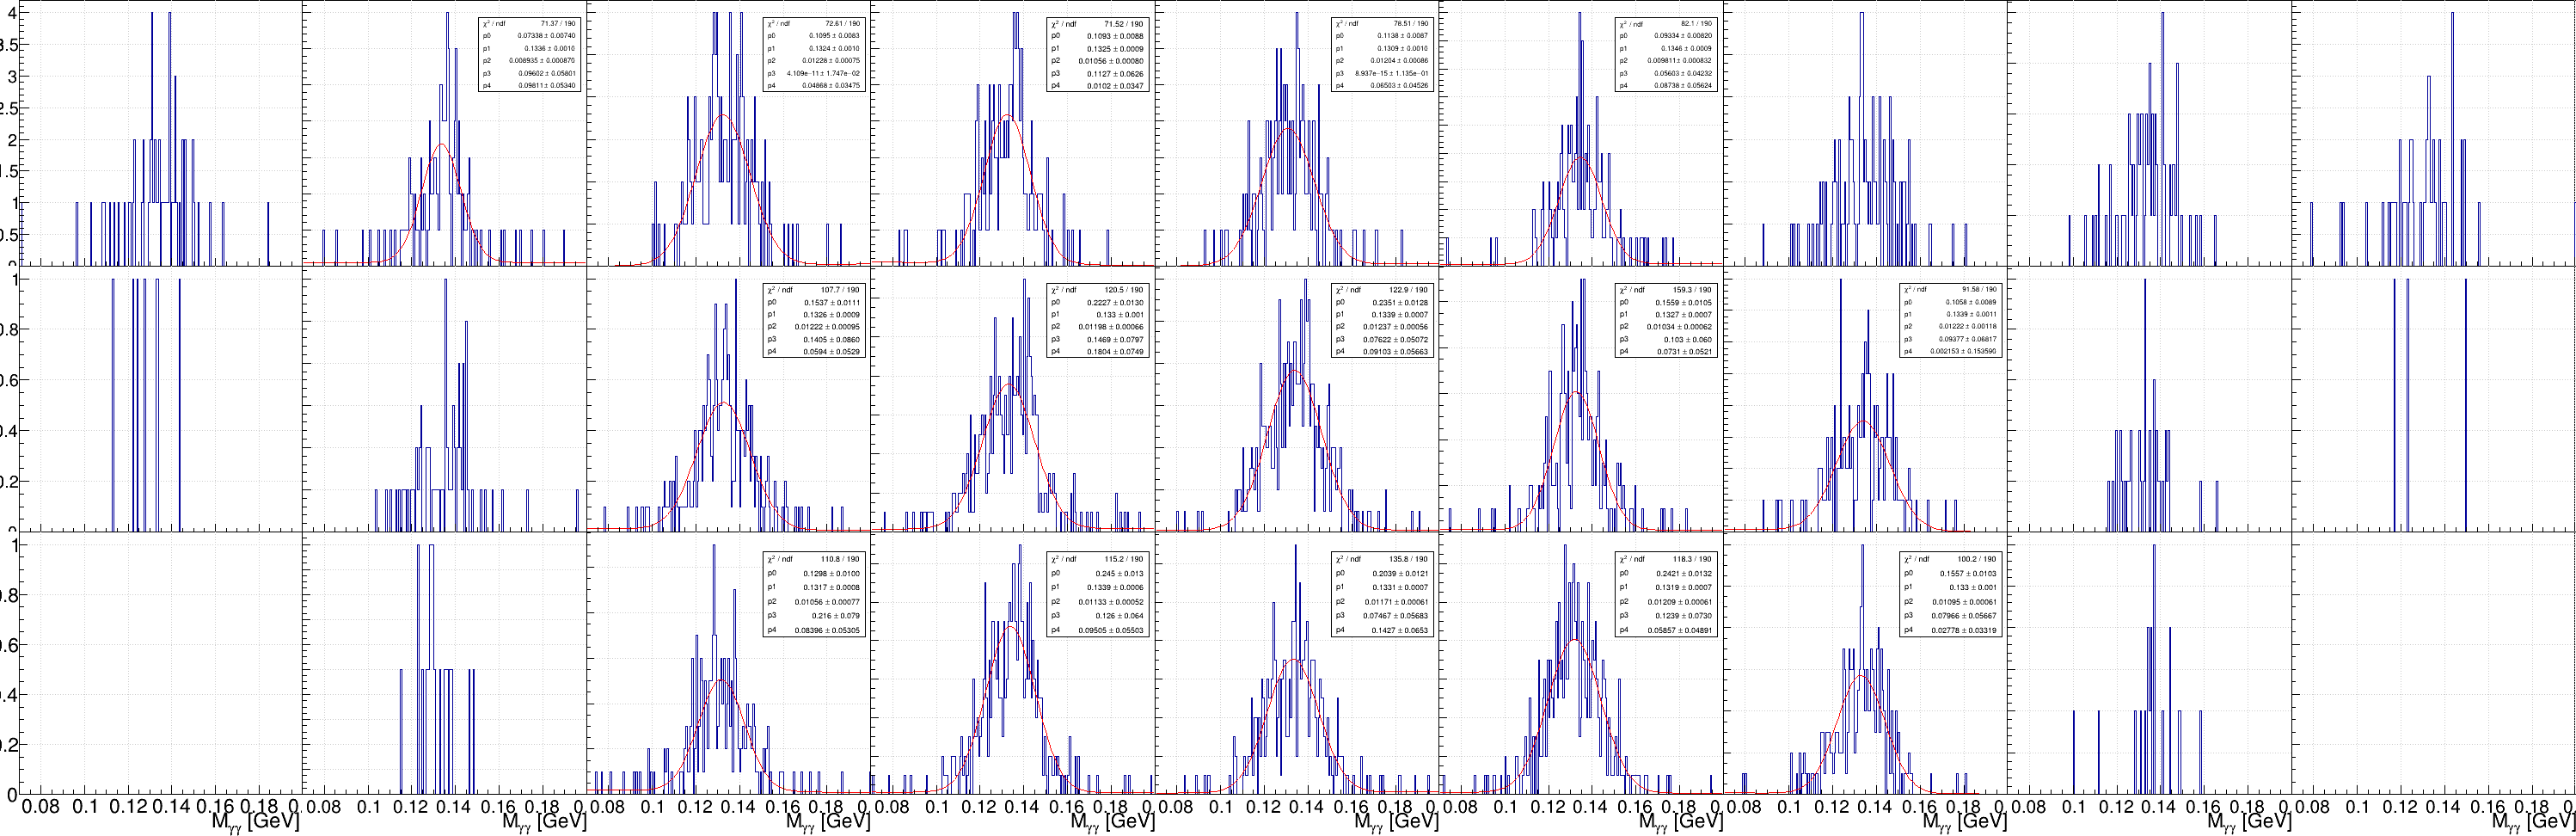

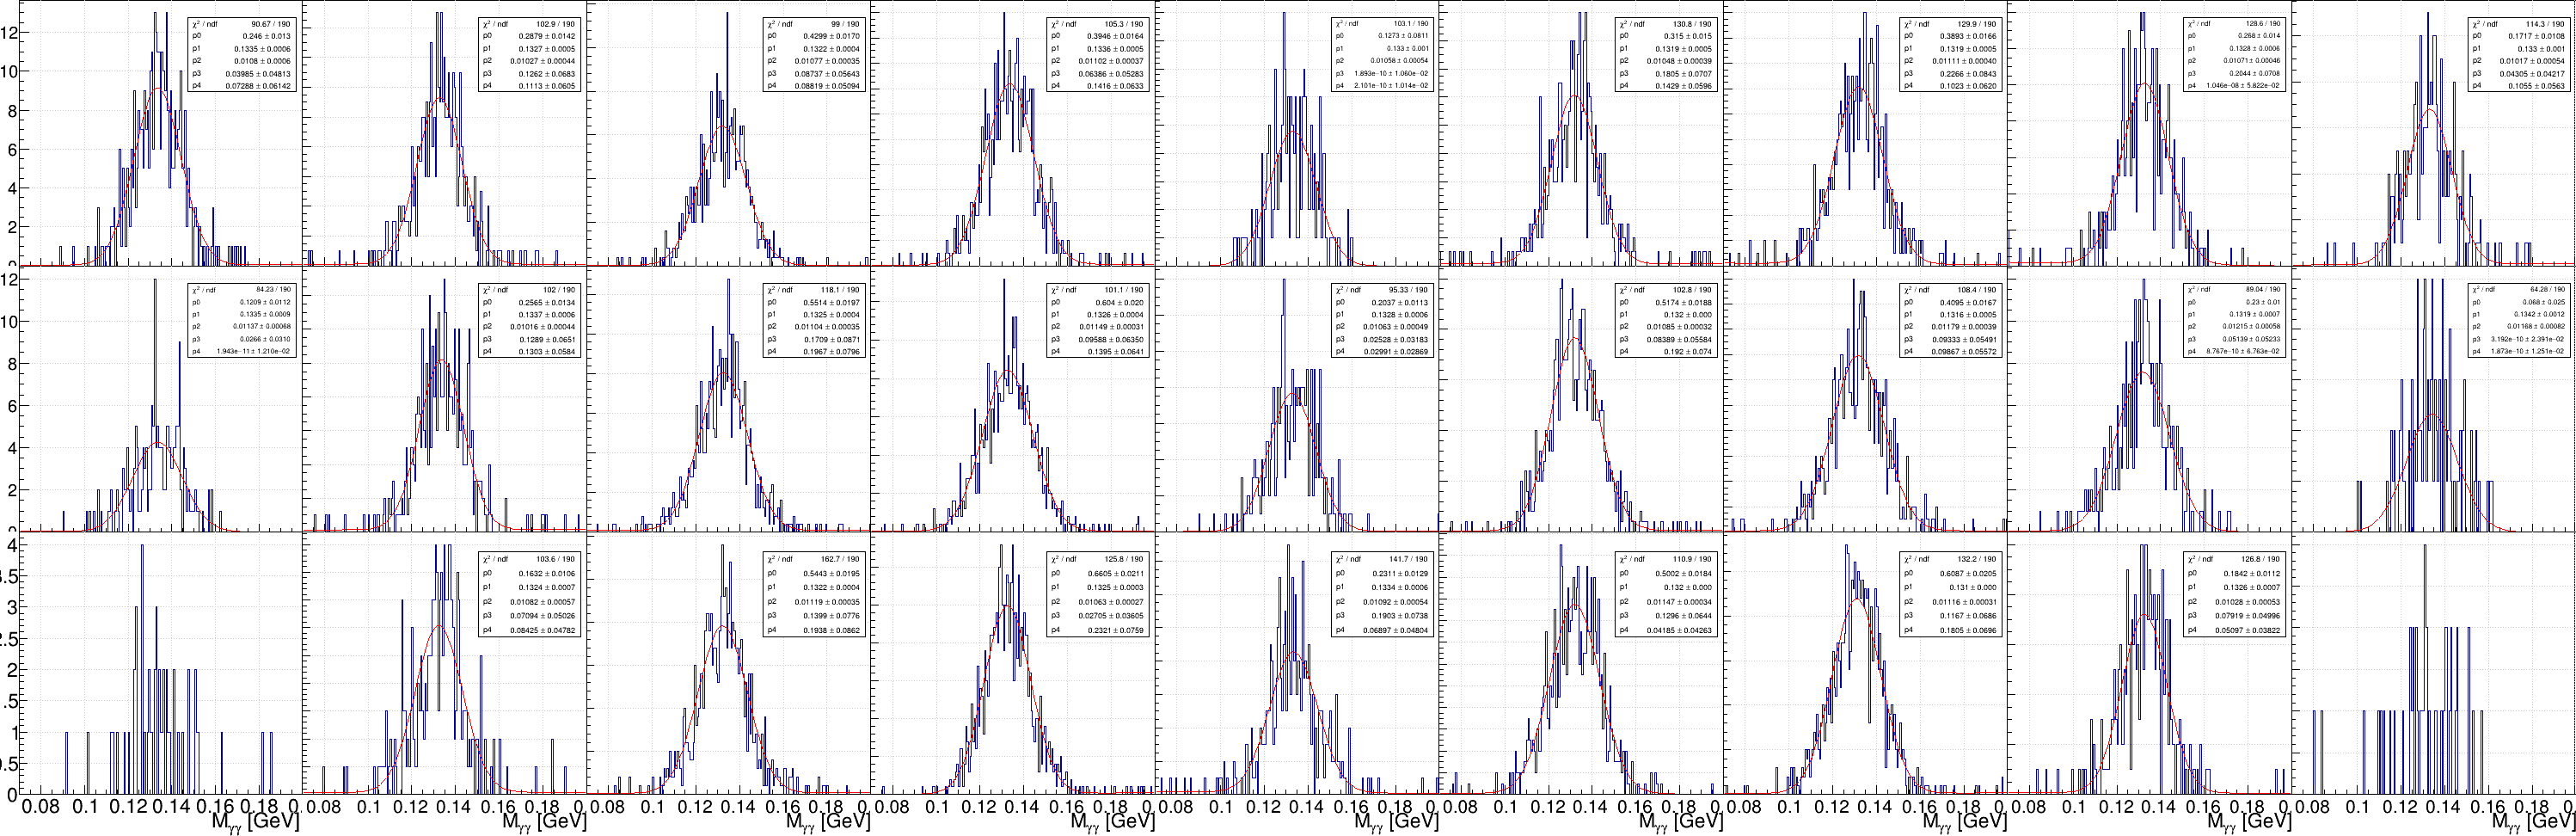

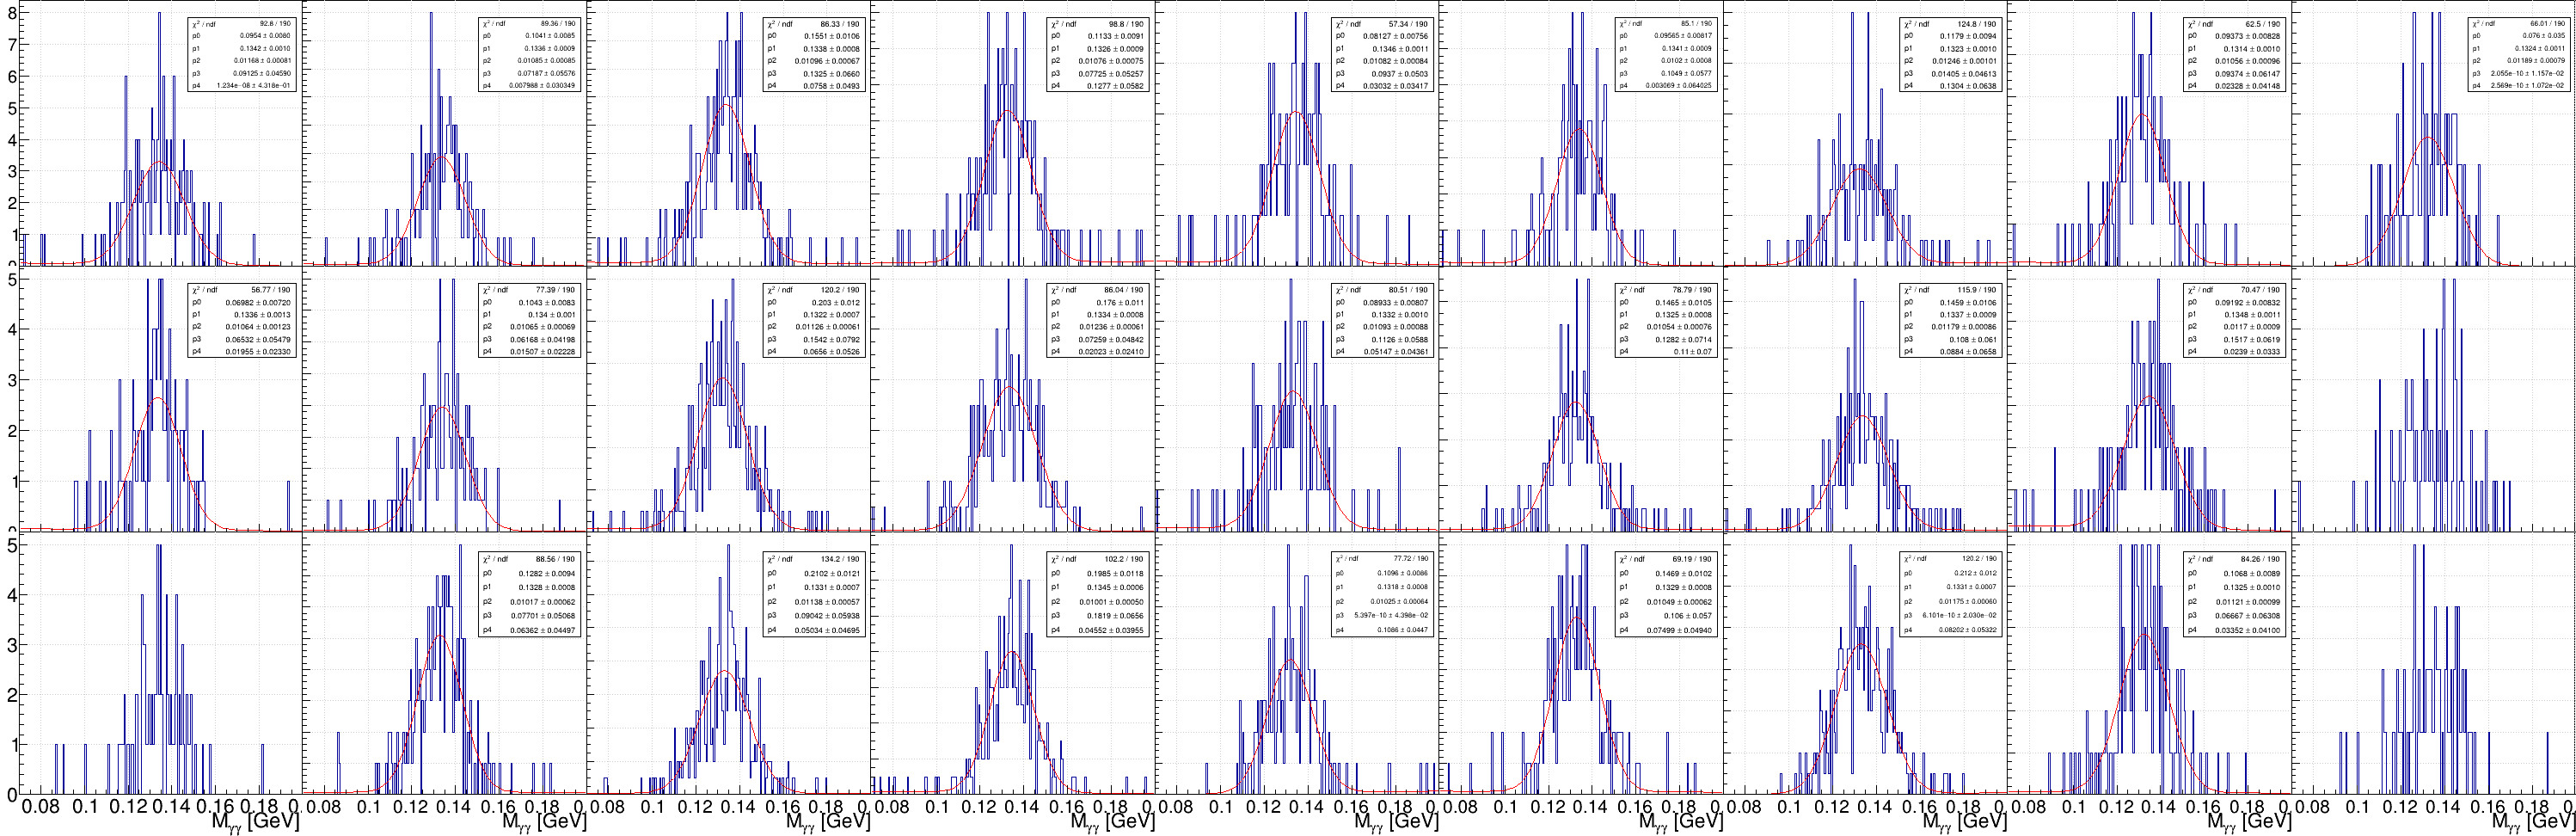

In [5]:
c1s=[]

pdfid = 'inb.pos'
inb,outb = rdfs
for qdf in inb.qdfs:
    ipad=0
    c1 = ROOT.TCanvas(f"can{qdf.binid}","c1",3000,1000)
    c1.SetTopMargin(0)
    c1.SetRightMargin(0)
    c1.Divide(9,3,0,0)
    c1.Draw()
    c1s.append(c1)

    for tdf in qdf.tdfs:
        for fdf in tdf.fdfs:
            ipad+=1
            c1.cd(ipad)

            fdf.hpos.SetTitle("")
            fdf.hpos.Draw()
            continue
            
            f1 = fdf.hpos.GetListOfFunctions().First()
            if f1:
                f1.SetLineColor(4)
            fdf.hneg.SetLineColor(2)
            fdf.hneg.Draw('sames')
            st = fdf.hneg.FindObject("stats")
            if st:
                st.SetY1NDC(0.37)
                st.SetY2NDC(0.65)
                st.SetLineColor(2)
                st.SetTextColor(2)

c1s[0].Print(f"pdf/mgg.eachbin.{pdfid}.pdf[")
for c1 in c1s:
    c1.Print(f"pdf/mgg.eachbin.{pdfid}.pdf[")
c1s[0].Print(f"pdf/mgg.eachbin.{pdfid}.pdf]")

____________________________

____________________________

____________________________

# Background to signal ratio

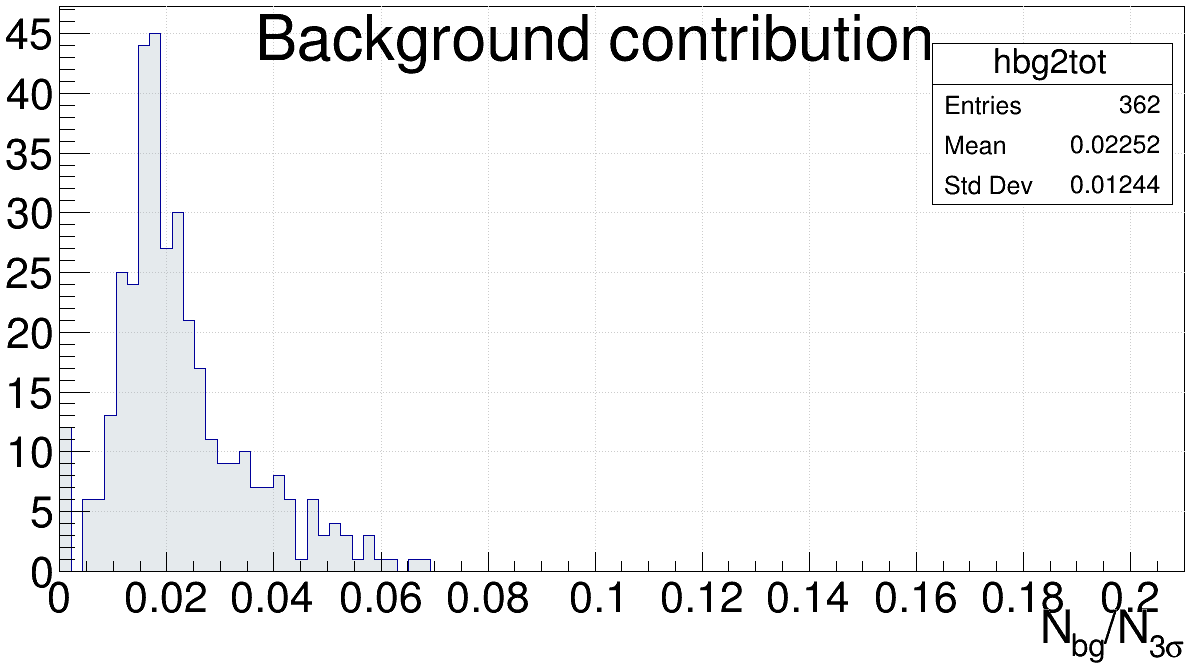

In [6]:
bgtot = []
for rdf in rdfs:
    for qdf in rdf.qdfs:
        for tdf in qdf.tdfs:
            for tot,bg in tdf.totbg:
                bgtot.append(bg/tot)

hbg2tot = ROOT.TH1F("hbg2tot","Background contribution;N_{bg}/N_{3#sigma}",100,0,0.21)
for bgr in bgtot:
    hbg2tot.Fill(bgr)
    
c1 = ROOT.TCanvas("c1","c1",1200,700)
c1.SetMargin(0.05,0.01,0.15,0.01)
c1.Draw()
hbg2tot.Draw()
ROOT.gStyle.SetOptStat(1)
hbg2tot.SetFillColorAlpha(33,0.3)

c1.Print("pdf/eppi0.backgroundratio.pdf")

____________________________

____________________________

____________________________

# Comparison with available CLAS6 data
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


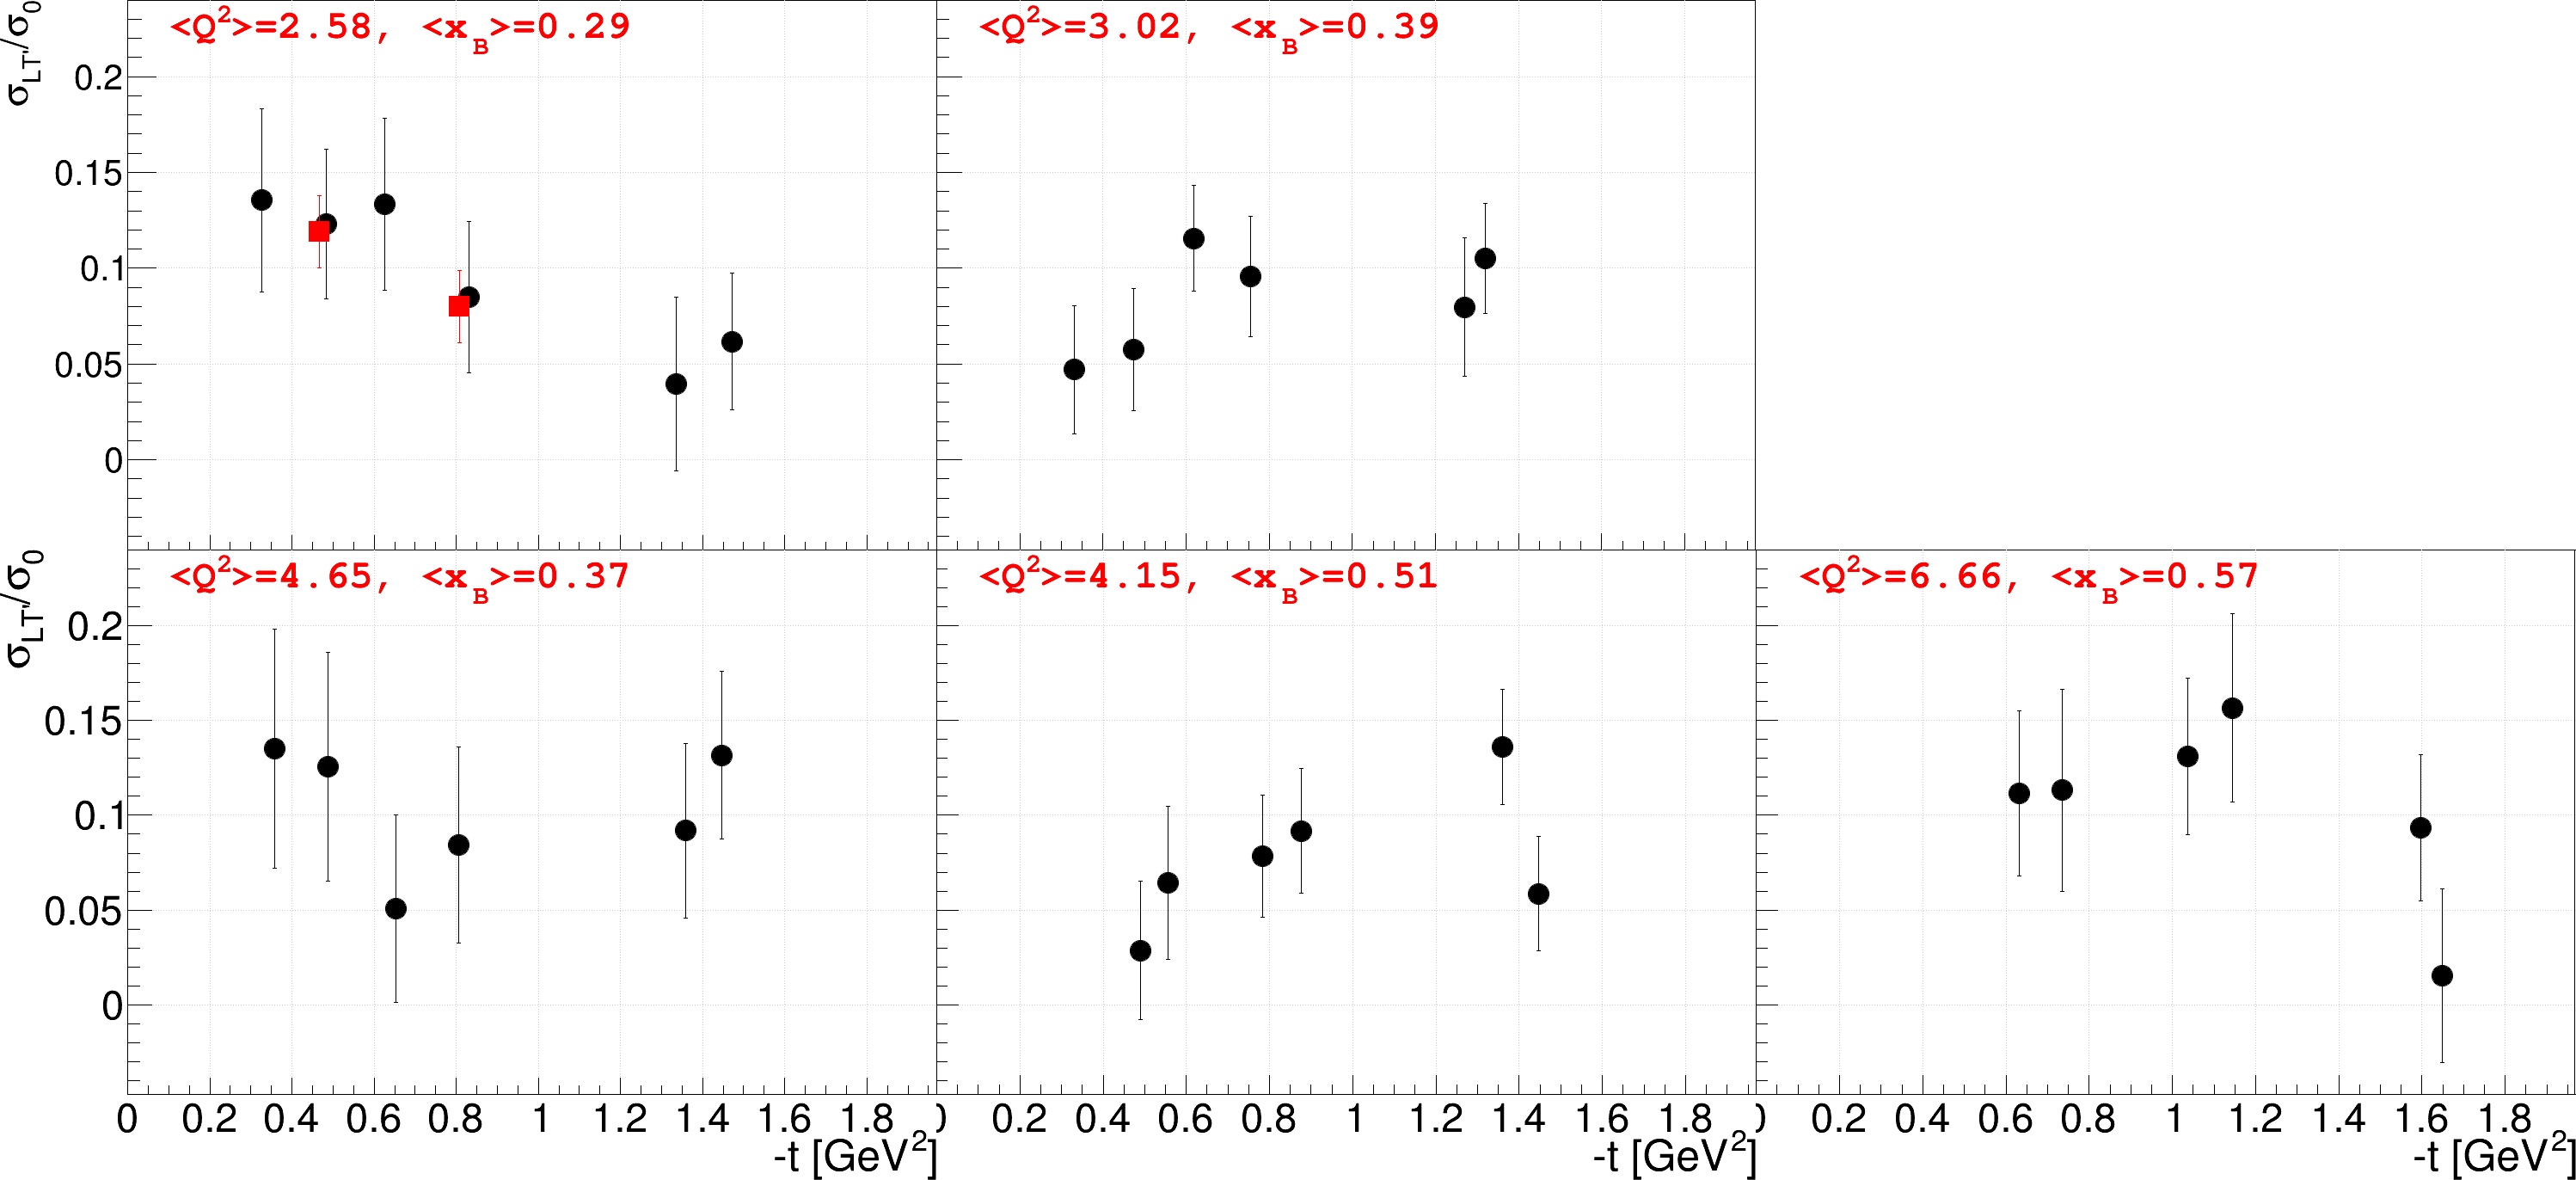

In [7]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

lat = ROOT.TLatex()
lat.SetTextFont(103)
lat.SetTextSize(50)
lat.SetTextColor(2)

def eps(q2,xb,E0):
    y = q2/2/0.938/xb/E0
    g2 = (2*xb*0.938)**2/q2
    eps = (1-y-0.25*y*y*g2)/(1-y+0.5*y*y+0.25*y*y*g2)
    return eps

def kinf(q2,xb,E0):
    return math.sqrt(2*eps(q2,xb,E0)*(1-eps(q2,xb,E0)))


gr6 = ROOT.TGraphErrors()
gr6.SetMarkerStyle(21)
gr6.SetMarkerColor(2)
gr6.SetLineColor(2)
for tt,alu,dalu1,dalu0 in [(0.467, 0.119, 0.016, 0.010), (0.809, 0.080, 0.016, 0.010)]:
    gr6.SetPoint(gr6.GetN(), tt, alu)
    gr6.SetPointError(gr6.GetN()-1, 0, math.sqrt(dalu1*dalu1 + dalu0*dalu0))
    


ipad=0
idf,odf = rdfs[:2]
for iqdf in idf.qdfs:
    oqdf = odf.shards[iqdf.binid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.24)
    h1.SetTitle(";-t [GeV^{2}];#sigma_{LT'}/#sigma_{0}");
    
    lat.DrawLatex(0.1,0.22,f"<Q^{{2}}>={round(iqdf.q2,2)}, <x_{{B}}>={round(iqdf.xb,2)}")
    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for i in range(3):
        q2,xb = iqdf.tdfs[i].q2, iqdf.tdfs[i].xb
        kf = kinf(q2,xb,10.6041)
        gr0.SetPointY(i, gr0.GetPointY(i)/kf)
        gr0.SetPointError(i, 0, gr0.GetErrorY(i)/kf)
        
        q2,xb = oqdf.tdfs[i].q2, oqdf.tdfs[i].xb
        kf = kinf(q2,xb,10.6041)
        gr1.SetPointY(i, gr1.GetPointY(i)/kf)
        gr1.SetPointError(i, 0, gr1.GetErrorY(i)/kf)

    gr0.Draw("P")
    gr1.Draw("P")
    if ipad==1: gr6.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

c1.Print("pdf/results.ALU.withclas6.pdf")


____________________________

____________________________

____________________________

# Theory comparison
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


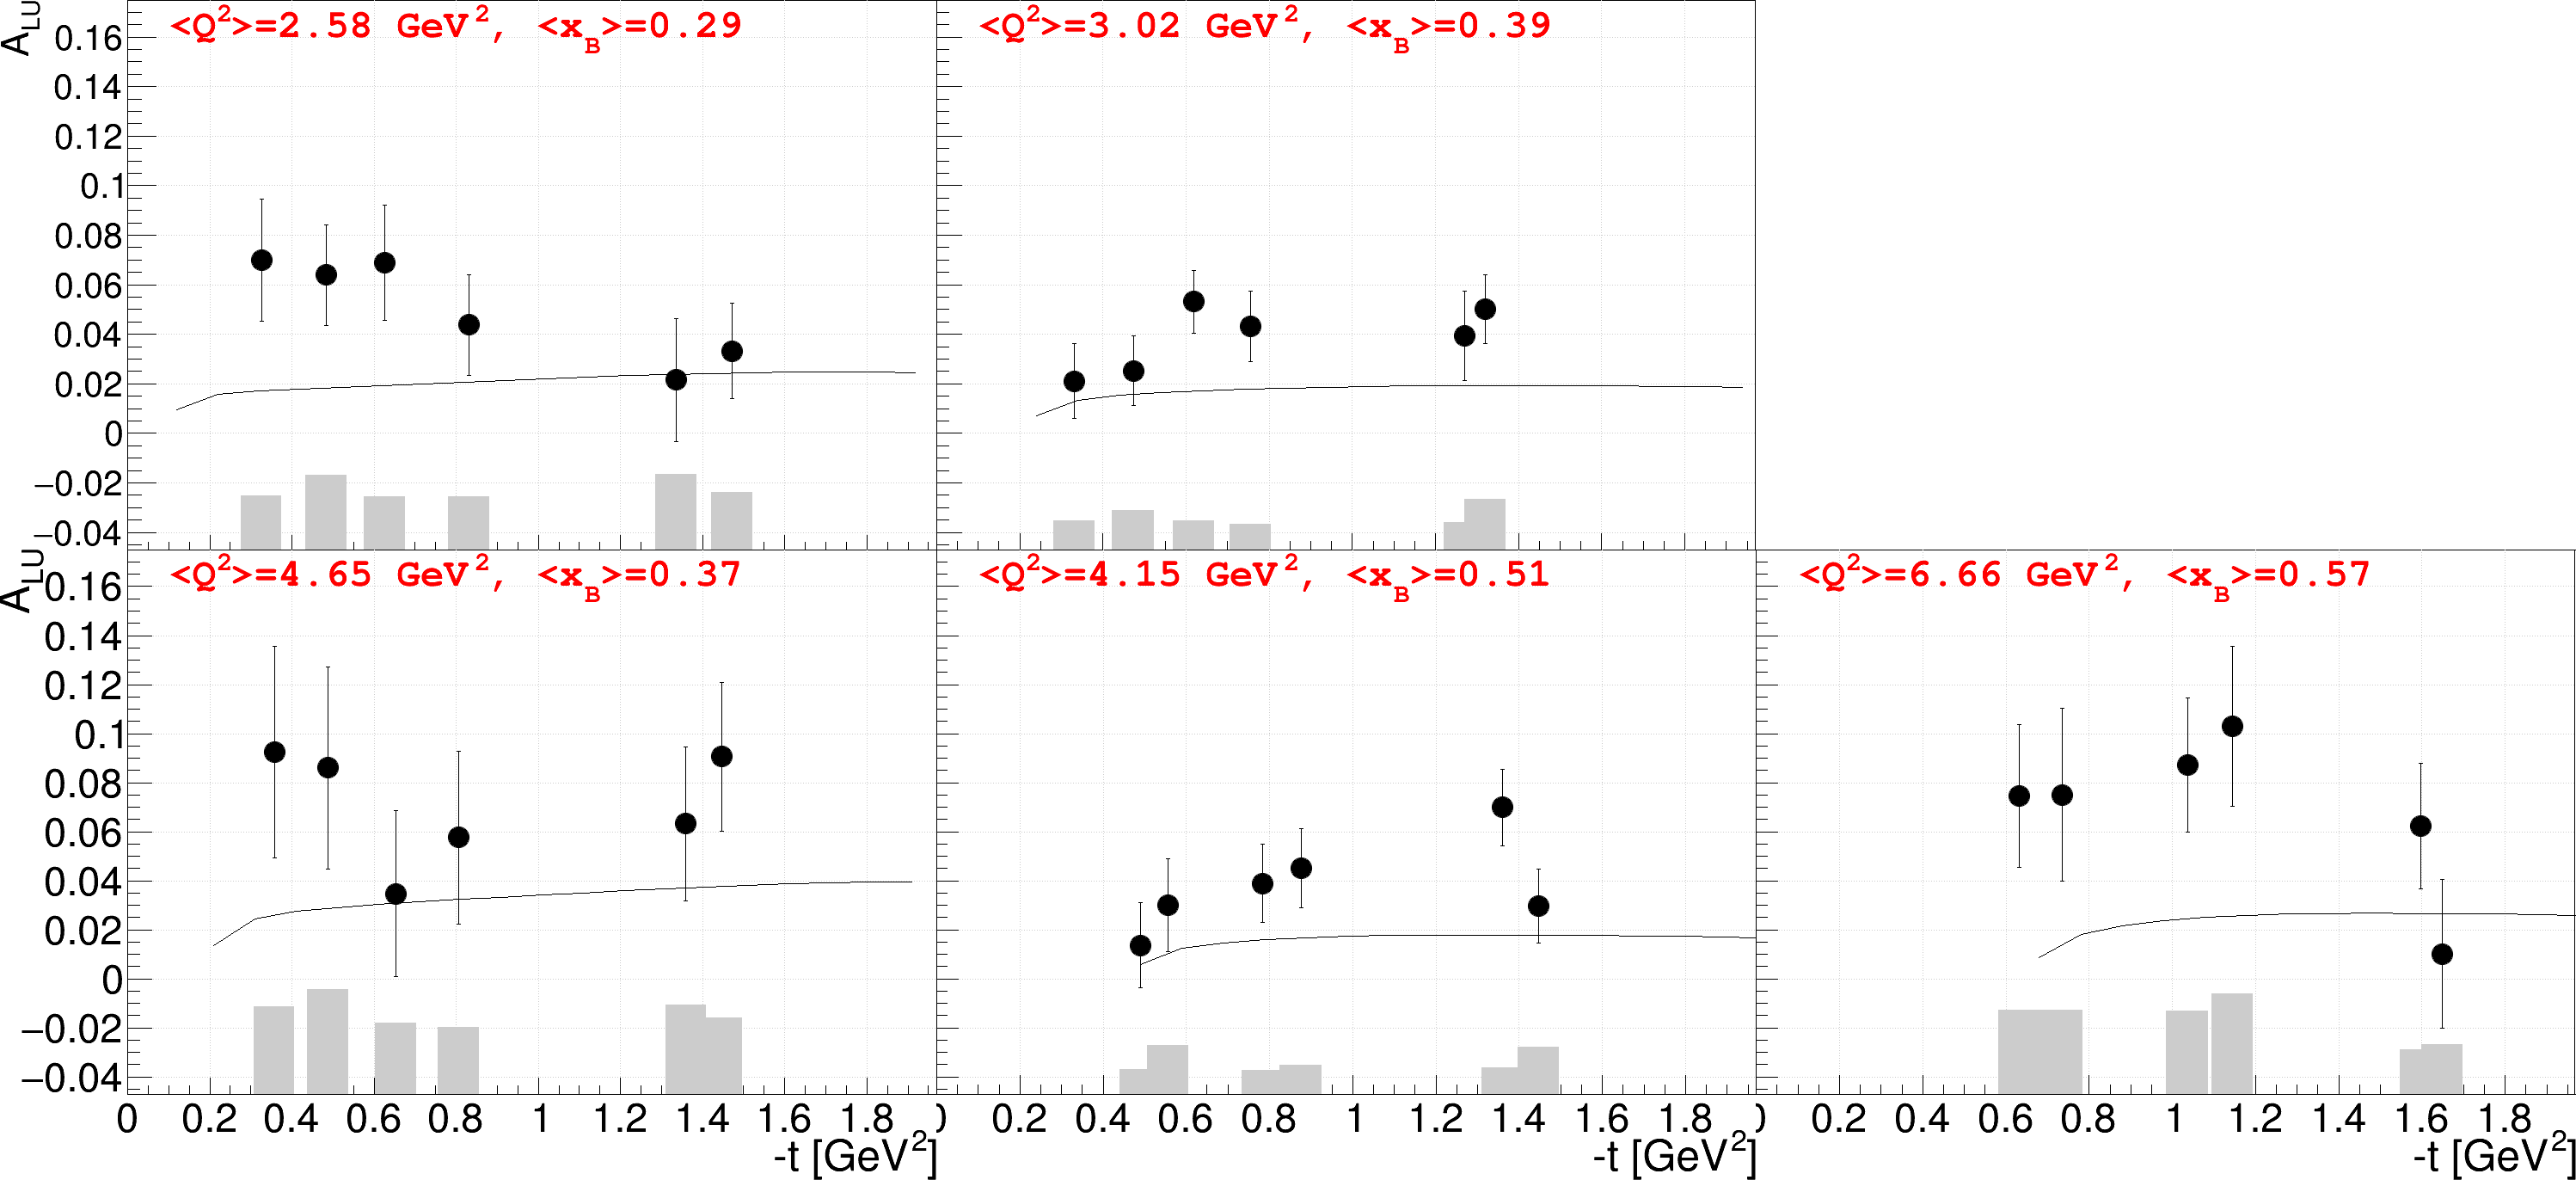

In [8]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

lat = ROOT.TLatex()
lat.SetTextFont(103)
lat.SetTextSize(50)
lat.SetTextColor(2)

with open("all.systematics.json") as ff:
    jsys = json.load(ff)
dsys = {eval(kk): math.sqrt(sum(vv*vv for vv in jsys[kk])) for kk in jsys}


grgks = []
for fn in ['2.60_0.29.dat', '3.03_0.39.dat', '4.68_0.37.dat', '4.15_0.51.dat', '6.70_0.57.dat']:
    grgk = ROOT.TGraph()
    with open('vpk/'+fn) as ff:
        for line in ff:
            q2,xb,mt,eps,sl,st,stt,alu0,alu1,slt = [float(vv) for vv in line.strip().split()]
            grgk.SetPoint(grgk.GetN(), -mt, alu1)
    grgks.append(grgk)
    
ipad,grs = 0,[]
idf,odf = rdfs[:2]
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.175)
    h1.SetTitle(f";-t [GeV^{{2}}];A_{{LU}}");
    lat.DrawLatex(0.1,0.16,f"<Q^{{2}}>={round(iqdf.q2,2)} GeV^{{2}}, <x_{{B}}>={round(iqdf.xb,2)}")
    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    grsys = ROOT.TGraphErrors()

    #for i in range(3):
    #    print(" & ".join(str(round(vv,3)) for vv in [iqdf.tdfs[i].q2, iqdf.tdfs[i].xb, iqdf.tdfs[i].tt, iqdf.grp1.GetPointY(i), iqdf.grp1.GetErrorY(i)]) + " \\\\")
    #    print(" & ".join(str(round(vv,3)) for vv in [oqdf.tdfs[i].q2, oqdf.tdfs[i].xb, oqdf.tdfs[i].tt, oqdf.grp1.GetPointY(i), oqdf.grp1.GetErrorY(i)]) + " \\\\")
    for itt in range(3):
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys[(0,bid[0],itt)])
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys[(1,bid[0],itt)])

    gr0.Draw("P")
    gr1.Draw("P")

    grgks[iqdf.binid[0]].Draw("L")
    grs.append(grsys)
    
    grsys.Draw("2")
    grsys.SetFillColor(17)
    
    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

c1.Print("pdf/results.ALU.withGKmodel.pdf")


____________________________

____________________________

____________________________

# MISC

119.0
0.48838436930820867


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


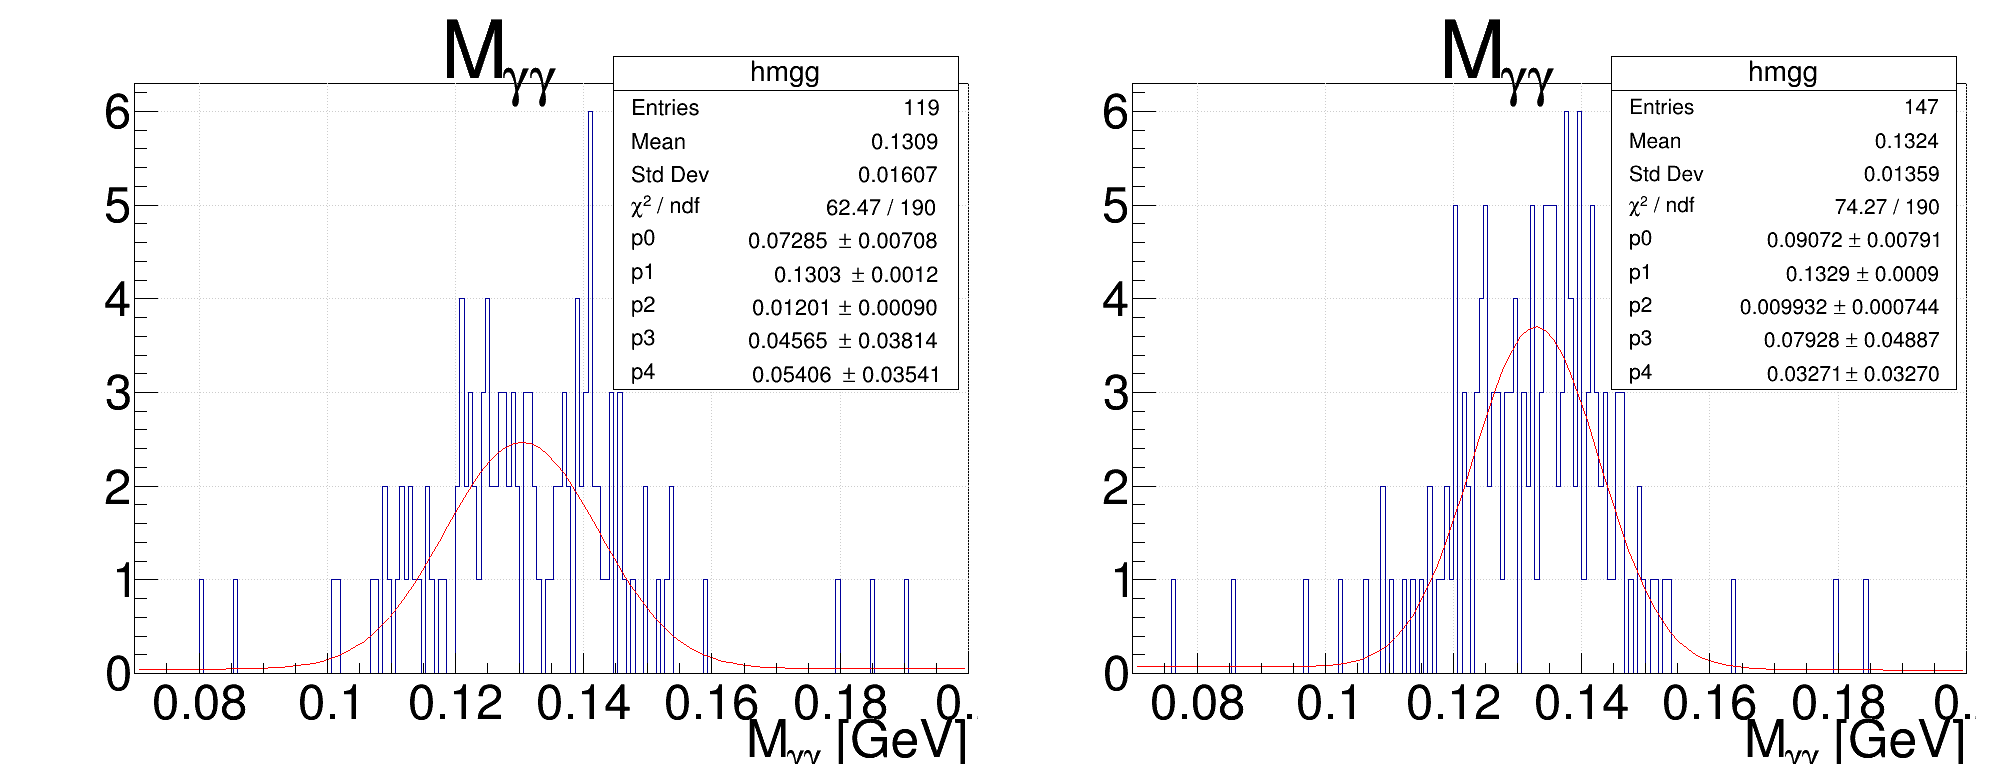

In [9]:
c1 = ROOT.TCanvas("c1","c1",2000,800)
c1.Divide(2,1)
c1.Draw()
aa=rdfs[1].qdfs[2].tdfs[0].fdfs[5]

c1.cd(1)
aa.hneg.Draw()
print(aa.hneg.GetEntries())
c1.cd(2)
aa.hpos.Draw()

print(rdfs[1].qdfs[2].tdfs[0].tt)